In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
import os
import matplotlib.pyplot as plt
import difflib 
# from slugify import slugify
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
drive.flush_and_unmount()
drive.mount("/content/drive")


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Проверка того, что гугл-диск примонтировался нормально.

In [ ]:
%cd /content/drive/MyDrive/
!ls -htl | head

/content/drive/MyDrive
ls: dataset_music: No such file or directory
ls: 'Project 4 - Tardigrades': No such file or directory
ls: dataset_music_1: No such file or directory
total 3.1G
-rw------- 1 root root 114K Apr 21 12:15 df_37.csv
-rw------- 1 root root  151 Apr 21 08:47 2_5474255836765229062.treefile.gdoc
-rw------- 1 root root 2.8M Apr 20 09:13 rf_dumped.pkl
-rw------- 1 root root  38K Apr 20 01:32 df_with_filenames.csv
lrw------- 1 root root    0 Apr 19 23:00 dataset_music_1 -> /content/drive/.shortcut-targets-by-id/1v7o9_3A1QAHXSilyufeUpeLNrWXqn7nm/dataset_music
-rw------- 1 root root  21K Apr 19 22:41 diff_table_files.csv
-rw------- 1 root root  99K Apr 19 19:51 spotified_data_for_classifier.csv
lrw------- 1 root root    0 Apr 18 18:24 Project 4 - Tardigrades -> /content/drive/.shortcut-targets-by-id/1jwGSmhyapfd0ctUfVWxhh7qrQdfROmIE/Project 4 - Tardigrades
-rw------- 1 root root  151 Apr 17 13:06 Копия Neutrality task.gsheet


In [ ]:
!nvidia-smi

Wed Apr 21 14:22:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Импорт метаданных и подготовка тегов

Аутенфикация в гугл-таблицах через токен.

In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

Импорт в pandas данных предобратанных @Neck_wrecker

In [ ]:
sht2 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1eC9WMRORSHYfUqa9woZIGfYGYYdY0PzvWWpcamvR5Cc/edit#gid=0').sheet1
rows = sht2.get_all_values()
headers = rows.pop(0)
df = pd.DataFrame.from_records(rows, columns=headers)
df.song

0                   Нет_мира_без_тебя-Ранетки
1      Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar
2                       Precious-Depeche_Mode
3                     Ultima_Thule-Oxxxymiron
4                                  Unravel-TK
                        ...                  
347       The_Veldt-deadmau5_feat_Chris_James
348    The_Violent_Sequence-Worriedaboutsatan
349                      Voyager-Jasper_Byrne
350                               Youth-Baril
351               Chop_It-Savant_&_Gino_Sydal
Name: song, Length: 352, dtype: object

Сколько coarse_genre у нас в табличке?\
50\
Из которых > 10:\
Electonic, Rock, Metal, Hip-Hop, Pop, Symphonic_Metal, Folk, Indie\
Остальное я бы отнёс в Other, чтобы не страдать


In [ ]:
df[['song','coarse_genre']].groupby("coarse_genre").count().sort_values('song', ascending=False)
# df[['song','coarse_genre']].groupby("coarse_genre").count().sort_values('song', ascending=False).count()

,song
coarse_genre,
Electronic,77
Rock,56
Metal,32
Hip-Hop,29
Pop,21
Symphonic_Metal,18
Folk,15
Indie,14
Jazz,9


In [ ]:
df.columns

Index(['student', 'song', 'coarse_genre', 'genre1', 'genre2', 'genre3'], dtype='object')

### Поиск соответсвия между названиями файлов в табличке и в папке

In [ ]:
len(df)

352

In [ ]:
names = df.song.to_list()

In [ ]:
files = [ os.path.splitext(f)[0] for f in os.listdir('dataset_music/data/')]

In [ ]:
!ls dataset_music/data/ | wc -l

322


In [ ]:
!ls dataset_music_1/data/ | wc -l

322


In [ ]:

diff = [ difflib.get_close_matches(x, names) for x in files]
diff.count([])

15

In [ ]:
diff = [ difflib.get_close_matches(x, files) for x in names]
diff.count([])

Добавлены названия файлов.

In [ ]:
diff_d = {x:difflib.get_close_matches(x, names, n=1) for x in files}
df_diff = pd.DataFrame.from_dict(diff_d, orient="index", columns=['song'])
df_diff.reset_index(inplace=True)
df_diff = df_diff.rename(columns = {'index':'file_names'})
df_diff['diff'] = df_diff['file_names'].ne(df_diff['song'])
names_alone = [ x for x in names if x not in df_diff[df_diff['song'].notna()].song.to_list()]
dirty_diff = {x:difflib.get_close_matches(x, names_alone, n=1,  cutoff=0.3 ) for x in df_diff[df_diff['song'].isna()].file_names.to_list()}
dirty_diff['Tycho-Awake'] = ['Japan - Tycho, Saint Sinner, Satin Jackets']
df_diff_dirty = pd.DataFrame.from_dict(dirty_diff, orient="index", columns=['song'])
df_diff_dirty.reset_index(inplace=True)
df_diff_dirty = df_diff_dirty.rename(columns = {'index':'file_names'})
df_diff = df_diff.dropna(axis='rows')
df_diff_dirty = df_diff_dirty.dropna(axis='rows')
df_diff = df_diff.drop(columns=['diff'])
df_diff = pd.concat([df_diff, df_diff_dirty])
df_diff.to_csv('diff_table_files.csv')
df_diff

,file_names,song
0,Tartessos_The_Hidden_Xenocryst-Allegaeon,Tartessos:_The_Hidden_Xenocryst-Allegaeon
1,Mardy_Bum-Arctic_Monkeys,Mardy_Bum-Arctic_Monkeys
2,Rock_Me_Baby-B_B_King,Rock_Me_Baby-B_B_King
3,Woman_In_Love-Barbara_Streisand,Woman_In_Love-Barbara_Streisand
4,Smoke_On_The_Water-Deep_Purple,Smoke_On_The_Water-Deep_Purple
...,...,...
8,Оргазм_Нострадамуса—Раздражение_аморала,Раздражение_аморала-Оргазм_Нострадамуса
9,Habibi—Tamino,Tamino-Habibi
10,The_Sound_Of_Silence-Simon_and_Garfunkel,The Sound of Silence -
11,Tycho-Awake,"Japan - Tycho, Saint Sinner, Satin Jackets"


In [ ]:
df_with_filenames = pd.merge(df, df_diff, on='song')
df_with_filenames.to_csv('df_with_filenames.csv')
df_with_filenames

,student,song,coarse_genre,genre1,genre2,genre3,file_names
0,Роман_Кругликов,Нет_мира_без_тебя-Ранетки,Rock,Pop_Rock,,,Нет_мира_без_тебя-Ранетки
1,Данил_Литвинов,Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar,Hip-Hop,Rap,Weas-Ccoast_Hip-Hop,,Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar
2,Данил_Литвинов,Precious-Depeche_Mode,Rock,Electronic_Rock,Soft_Rock,,Precious-Depeche_Mode
3,Данил_Литвинов,Ultima_Thule-Oxxxymiron,Hip-Hop,Rap,,,Ultima_Thule-Oxxxymiron
4,Данил_Литвинов,Unravel-TK,Rock,Anime,,,Unravel-TK
...,...,...,...,...,...,...,...
315,Паша_Дерябин,The_Veldt-deadmau5_feat_Chris_James,Electronic,House,,,The_Veldt-deadmau5_feat._Chris_James
316,Паша_Дерябин,The_Violent_Sequence-Worriedaboutsatan,Electronic,Techno,,,The_Violent_Sequence-Worriedaboutsatan
317,Паша_Дерябин,Voyager-Jasper_Byrne,Electronic,Synthwave,,,Voyager-Jasper_Byrne
318,Паша_Дерябин,Youth-Baril,Electronic,Downtempo,,,Youth-Baril


## Тестовый прогон тестового файла

In [ ]:
!ls dataset_music/data | grep "flac"

ls: cannot access 'dataset_music/data': No such file or directory


In [ ]:
!ls dataset_music/data/a*

ls: cannot access 'dataset_music/data/a*': No such file or directory


In [ ]:
track1 = 'datasdataset_music/data/'

Librosa жрёт флак

In [ ]:
sr = librosa.get_samplerate('dataset_music/data/Money_Machine-100_Gecs.flac')
audio_data = 'dataset_music/data/Money_Machine-100_Gecs.flac'
x, sr = librosa.load(audio_data, sr=sr)
sr

44100

In [ ]:
x

array([0.        , 0.        , 0.        , ..., 0.00022888, 0.00021362,
       0.00022888], dtype=float32)

In [ ]:
len(x)

5047688

In [ ]:
sr = 1000

In [ ]:
audio_data = 'dataset_music/data/Money_Machine-100_Gecs.flac'
x, sr = librosa.load(audio_data, sr=sr)
len(x)

5047688

Из графика видно, что я умею воровать код из интернета

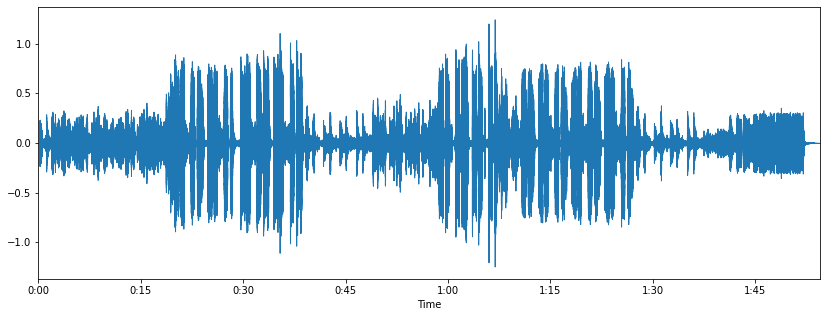

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

Из графика видно, что в треке не хватает басов.

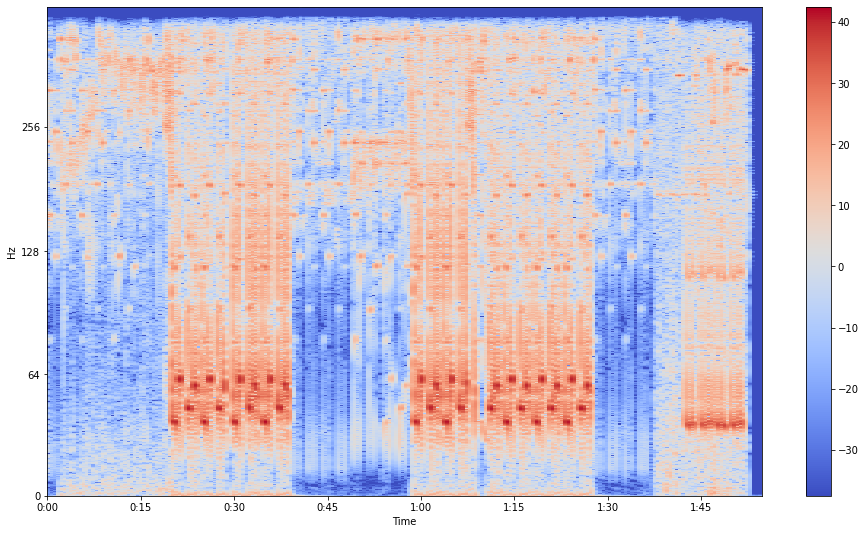

In [ ]:
X = librosa.stft(x)
plt.figure(figsize=(16, 9))
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

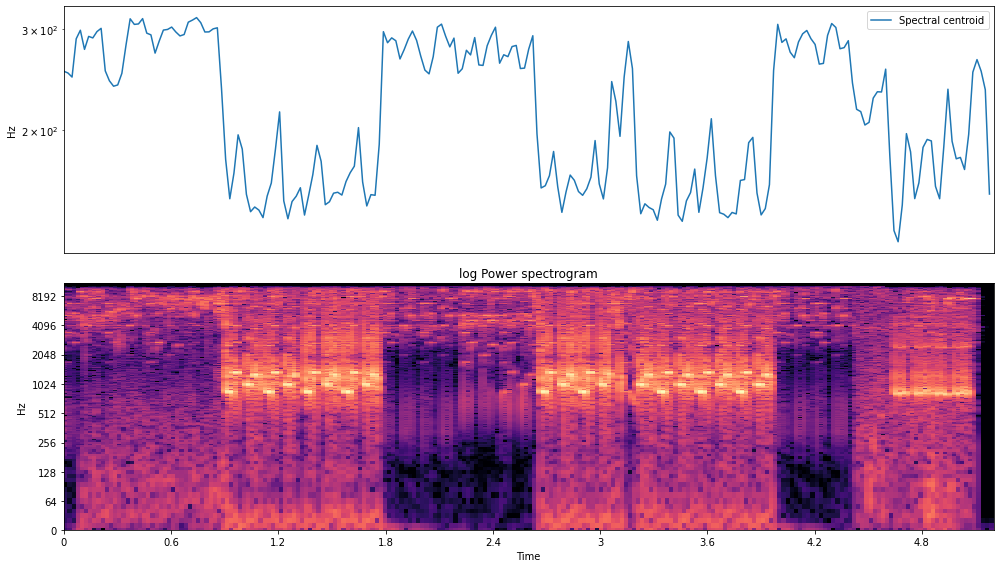

In [ ]:
cent = librosa.feature.spectral_centroid(x, sr=sr)

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()
plt.subplot(2, 1, 2)
S, phase = librosa.magphase(librosa.stft(x))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

### Импорт данных

нерабочее решение, решил не завёртывать в функцию

In [ ]:
def create_dict_from_files(d):
  sr = 1000
  x, sr = librosa.load(audio_data, sr=sr)
  cent = librosa.feature.spectral_centroid(x, sr=sr)
  d['Filename'] = cent

Импорт всех файлов, сохранение в json их spectral_centroid(cent) и сырых ридов(raw).\
Из-за специфики np arrays я превращаю их в python lists. Довольно тяжёлое решение, можно переделать для оптимизации кода.

In [ ]:
d = {}
sr = 1000

files = [f for f in listdir('dataset_music/data/')]

for f in files:
  raw, sr = librosa.load(f'dataset_music/data/{f}', sr=sr)
  cent = librosa.feature.spectral_centroid(raw, sr=sr)
  d[f] = {'raw':raw.tolist(), 'cent':cent[0].tolist()}


In [ ]:
with open('cent_mus.json', 'w') as fp:
    json.dump(d, fp)

In [ ]:
len(d)

322

In [ ]:
# len_list = [i for i in d.values()]
# len_list

dict_keys(['Tartessos_The_Hidden_Xenocryst-Allegaeon.mp3', 'Mardy_Bum-Arctic_Monkeys.mp3', 'Rock_Me_Baby-B_B_King.mp3', 'Woman_In_Love-Barbara_Streisand.mp3', 'Smoke_On_The_Water-Deep_Purple.mp3', 'Need_You_Tonight-INXS.mp3', 'Take_A_Look_Around-Limp_Bizkit.mp3', 'Lazy_Day-The_Moody_Blues.mp3', "Don't_Be_Cruel-Elvis_Presley.mp3", 'Назови_Мне_Свое_Имя-Lumen.mp3', "Puttin'_On_The_Ritz-The_Pasadena_Roof_Orchestra.mp3", 'John_Kerr-The_Sailors_Hornpipe.mp3', 'Mervent-Ascarabaz_Scottish.mp3', 'Электрослабость-Терентий.mp3', 'Признаки_жизни-Oxxxymiron.mp3', 'at_home-daktari_lorenz.mp3', 'Тихий_огонек_моей_души_remix-Високосный_Год.mp3', 'Unravel-TK.mp3', 'Orange-Seven_Oops.mp3', 'Неваляшка_Oxxxymiron.mp3', 'Ultima_Thule-Oxxxymiron.mp3', 'Переплетено-Oxxxymiron.mp3', 'Нимфоманка-Монеточка.mp3', 'Я_так_соскучился-Порнофильмы.mp3', 'Фанат-Эм_Калинин.mp3', 'Пой-bohochic.mp3', 'Варидейла-bohochic.mp3', 'Я_не_один-Эм_Калинин.mp3', 'Хостел-Аффинаж.mp3', 'Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar.

In [ ]:
short_cent = [i[0][:min(len_list)] for i in d.values()]
df_short_cen = pd.DataFrame(short_cent)
df_short_cen.set_index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205
0,153.139834,162.742550,161.810551,160.419993,159.420720,160.968051,162.555242,172.344354,168.307941,162.655928,159.645263,161.118539,163.862679,161.051471,164.691121,166.980663,165.299116,168.921968,170.302531,171.226991,170.471000,172.382024,168.227135,167.013152,171.180413,174.698357,173.461305,170.991335,172.778210,172.185753,178.906811,192.945214,204.149995,185.072309,182.201333,194.739146,203.457444,181.312534,188.686738,197.864090,...,185.845572,179.627826,189.722852,188.970865,181.063623,173.922378,176.094325,178.375143,173.713542,178.969748,186.967592,178.961906,176.285725,177.208209,173.927880,177.611469,181.791686,182.218301,180.160342,181.181943,172.340202,177.191163,182.245327,179.247352,182.894040,183.661780,175.088845,174.308051,179.887478,185.717572,183.038291,176.069821,173.794620,169.860559,163.197239,169.078149,169.824571,168.659266,163.649170,164.548015
1,329.174794,333.741802,334.388729,333.577062,326.977092,316.699442,311.499729,318.743012,306.393717,287.966541,296.953724,303.168917,306.211605,290.890810,216.551530,138.221118,159.161516,152.342982,174.522859,150.232572,150.955922,159.953198,161.682292,152.748711,143.190760,154.626867,154.868287,150.031874,132.050104,146.150268,154.216669,167.673366,137.823877,145.958746,149.661588,171.163191,140.561861,148.768163,151.538984,168.030286,...,160.538678,159.086330,171.761283,202.078444,181.401841,190.084761,190.640691,188.569957,163.312069,170.323952,171.007906,171.866073,176.964385,212.153920,194.259961,191.797787,184.101460,204.012093,193.836094,170.338475,160.580997,195.931086,190.472722,174.077374,171.078508,210.754093,223.961963,184.326919,163.797838,168.953469,179.350945,179.978265,177.226670,158.610207,164.613360,150.870778,134.821278,149.378605,192.201838,165.834779
2,140.154571,126.954921,126.155370,152.328729,157.816653,149.887116,155.019500,147.736181,133.835598,149.202648,146.207616,147.920103,155.338421,136.916556,149.358391,160.884962,148.082825,154.566064,149.688212,130.302747,148.364527,145.790089,144.343610,152.087153,134.148768,139.794424,164.882445,159.566807,156.524270,152.505016,127.165648,146.114969,152.334103,148.453151,148.925071,138.331367,135.743068,156.235897,158.873962,159.049290,...,159.346738,143.582313,153.228683,148.895225,142.131760,166.450109,161.371538,151.031331,160.098664,132.262183,134.002565,148.058364,137.128083,137.435137,140.196917,136.336757,162.535393,158.821608,151.561815,167.377296,152.404079,153.502837,162.460487,149.549245,159.036737,160.114210,133.856834,156.540189,169.890098,149.561663,153.923766,146.344832,148.564508,165.581835,156.464843,151.350008,164.671010,159.400316,167.031675,165.597513
3,163.975542,168.044157,181.699202,224.806116,205.746414,198.833177,226.436559,191.265518,201.314037,229.630581,195.072767,208.736098,190.055326,190.949935,224.738997,194.258144,183.858638,223.803914,185.557251,192.278364,216.511572,178.822130,187.492331,187.749551,175.151907,218.614249,196.141894,189.339821,229.172976,194.468853,204.295553,226.902730,183.451530,201.483303,199.832921,192.837813,222.580923,200.350185,184.636584,219.214289,...,207.708678,177.159418,173.953653,183.882976,194.674859,207.010563,226.754854,209.304056,203.240475,201.134711,206.528104,226.955314,200.251872,185.902938,205.007251,200.751471,210.817501,229.832024,209.099142,218.764564,203.128559,183.992991,220.531168,209.245027,200.216073,210.672307,192.544910,204.855147,226.069850,176.845398,203.815776,195.561757,169.372317,202.080929,186.058554,173.951913,213.285251,170.700213,181.459557,197.310995
4,253.194593,257.684752,247.802988,240.809408,247.984068,252.945532,249.032185,252.381171,245.577493,243.029856,237.442980,246.965096,244.028292,241.758427,251.451329,258.118464,240

## Лёшин великолепный Spotify


In [ ]:
dfs = pd.read_csv("spotified_data_for_classifier.csv")
dfs =  dfs.drop(columns=["Unnamed: 0"])
dfs

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track,artist,source_name
0,0.759,0.553,11,-8.489,0,0.0620,0.00437,0.000123,0.2200,0.5700,111.037,audio_features,6KMNLtxG9B9w32EKGz2ryk,spotify:track:6KMNLtxG9B9w32EKGz2ryk,https://api.spotify.com/v1/tracks/6KMNLtxG9B9w...,https://api.spotify.com/v1/audio-analysis/6KMN...,180372,4,Нет мира без тебя,Ranetki Girls,Нет_мира_без_тебя-Ранетки
1,0.587,0.698,1,-8.948,1,0.0943,0.01520,0.000000,0.4420,0.0985,133.954,audio_features,712uvW1Vezq8WpQi38v2L9,spotify:track:712uvW1Vezq8WpQi38v2L9,https://api.spotify.com/v1/tracks/712uvW1Vezq8...,https://api.spotify.com/v1/audio-analysis/712u...,310720,4,"Bitch, Don’t Kill My Vibe",Kendrick Lamar,Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar
2,0.568,0.837,1,-6.138,1,0.0266,0.09000,0.058700,0.0994,0.8530,104.988,audio_features,3c4bJL7mARZvd387847GsC,spotify:track:3c4bJL7mARZvd387847GsC,https://api.spotify.com/v1/tracks/3c4bJL7mARZv...,https://api.spotify.com/v1/audio-analysis/3c4b...,245867,4,Precious,Depeche Mode,Precious-Depeche_Mode
3,0.516,0.832,6,-5.350,0,0.0606,0.51500,0.000002,0.3610,0.5380,168.119,audio_features,11YO6bRr4WZiOlkgwu0IiF,spotify:track:11YO6bRr4WZiOlkgwu0IiF,https://api.spotify.com/v1/tracks/11YO6bRr4WZi...,https://api.spotify.com/v1/audio-analysis/11YO...,138373,4,Ultima Thule,Oxxxymiron,Ultima_Thule-Oxxxymiron
4,0.507,0.889,7,-2.755,0,0.0860,0.04950,0.000000,0.0983,0.3330,135.021,audio_features,0GLyqTysS0DFoeKjURtB8s,spotify:track:0GLyqTysS0DFoeKjURtB8s,https://api.spotify.com/v1/tracks/0GLyqTysS0DF...,https://api.spotify.com/v1/audio-analysis/0GLy...,238360,4,unravel,TK from Ling tosite sigure,Unravel-TK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.712,0.953,11,-8.409,1,0.0466,0.03880,0.914000,0.1110,0.2130,125.008,audio_features,74RlRknY02u9U0c76wXUqj,spotify:track:74RlRknY02u9U0c76wXUqj,https://api.spotify.com/v1/tracks/74RlRknY02u9...,https://api.spotify.com/v1/audio-analysis/74Rl...,341163,4,Tantrum,Throwing Snow,Tantrum-Throwing_Snow
296,0.736,0.759,9,-7.066,1,0.0347,0.05730,0.207000,0.0778,0.4850,128.039,audio_features,5H0CfA9GaNg0wROR9K3X3K,spotify:track:5H0CfA9GaNg0wROR9K3X3K,https://api.spotify.com/v1/tracks/5H0CfA9GaNg0...,https://api.spotify.com/v1/audio-analysis/5H0C...,170059,4,The Veldt - Radio Edit,deadmau5,The_Veldt-deadmau5_feat_Chris_James
297,0.463,0.525,6,-13.032,0,0.0598,0.13000,0.926000,0.1400,0.1520,125.056,audio_features,0VG7dnqLP38Jpvld0lMk5m,spotify:track:0VG7dnqLP38Jpvld0lMk5m,https://api.spotify.com/v1/tracks/0VG7dnqLP38J...,https://api.spotify.com/v1/audio-analysis/0VG7...,376320,4,The Violent Sequence,Worriedaboutsatan,The_Violent_Sequence-Worriedaboutsatan
298,0.685,0.630,1,-10.909,1,0.0417,0.06700,0.841000,0.1040,0.7880,119.993,audio_features,1bweOqaO6SIGRRMupc7zMm,spotify:track:1bweOqaO6SIGRRMupc7zMm,https://api.spotify.com/v1/tracks/1bweOqaO6SIG...,https://api.spotify.com/v1/audio-analysis/1bwe...,214154,4,Voyager - Original Mix,Jasper Byrne,Voyager-Jasper_Byrne


### Добавление метаданных

Все жанры кроме 7 топовых преобразованы в Other

In [ ]:
df_to_s = df.rename(columns = {'song':'source_name'})
dfs = pd.merge(dfs, df_to_s, on='source_name')

NameError: ignored

In [ ]:
main_genres = dfs[['source_name','coarse_genre']].groupby("coarse_genre").count().sort_values('source_name', ascending=False).index[:7].to_list()

In [ ]:
dfs['basic_genre'] = dfs['coarse_genre']
dfs.loc[~dfs["basic_genre"].isin(main_genres), "basic_genre"] = "Other"
dfs.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track', 'artist', 'source_name', 'student',
       'coarse_genre', 'genre1', 'genre2', 'genre3', 'basic_genre'],
      dtype='object')

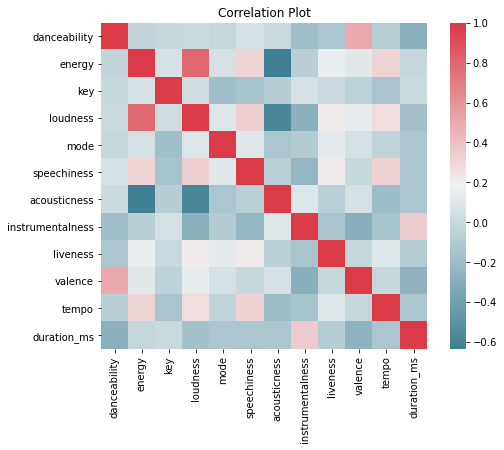

In [ ]:
corr_df=x_train
cor= corr_df.corr(method='pearson')

fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

### Локальный лес

In [ ]:
dfs = pd.read_csv("~/storage/drive/spotified_data_for_classifier.csv")
df = pd.read_csv("~/storage/drive/genres.csv")
dfs =  dfs.drop(columns=["Unnamed: 0"])
df_to_s = df.rename(columns = {'song':'source_name'})
dfs = pd.merge(dfs, df_to_s, on='source_name')
main_genres = dfs[['source_name','coarse_genre']].groupby("coarse_genre").count().sort_values('source_name', ascending=False).index[:7].to_list()
dfs['basic_genre'] = dfs['coarse_genre']
dfs.loc[~dfs["basic_genre"].isin(main_genres), "basic_genre"] = "Other"
pd.Series(dfs.basic_genre).value_counts()

FileNotFoundError: ignored

In [ ]:
dfs = pd.read_csv("~/storage/drive/df_37.csv")
dfs

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,time_signature,track,artist,source_name,student,coarse_genre,genre1,genre2,genre3
0,0,0.759,0.553,11,-8.489,0,0.0620,0.00437,0.000123,0.2200,...,180372,4,Нет мира без тебя,Ranetki Girls,Нет_мира_без_тебя-Ранетки,Роман_Кругликов,Rock,Pop_Rock,NaN,NaN
1,1,0.587,0.698,1,-8.948,1,0.0943,0.01520,0.000000,0.4420,...,310720,4,"Bitch, Don’t Kill My Vibe",Kendrick Lamar,Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar,Данил_Литвинов,Hip-Hop,Rap,Weas-Ccoast_Hip-Hop,NaN
2,2,0.568,0.837,1,-6.138,1,0.0266,0.09000,0.058700,0.0994,...,245867,4,Precious,Depeche Mode,Precious-Depeche_Mode,Данил_Литвинов,Rock,Electronic_Rock,Soft_Rock,NaN
3,3,0.516,0.832,6,-5.350,0,0.0606,0.51500,0.000002,0.3610,...,138373,4,Ultima Thule,Oxxxymiron,Ultima_Thule-Oxxxymiron,Данил_Литвинов,Hip-Hop,Rap,NaN,NaN
4,4,0.507,0.889,7,-2.755,0,0.0860,0.04950,0.000000,0.0983,...,238360,4,unravel,TK from Ling tosite sigure,Unravel-TK,Данил_Литвинов,Rock,Anime,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0.712,0.953,11,-8.409,1,0.0466,0.03880,0.914000,0.1110,...,341163,4,Tantrum,Throwing Snow,Tantrum-Throwing_Snow,Паша_Дерябин,Electronic,Dubstep,NaN,NaN
296,296,0.736,0.759,9,-7.066,1,0.0347,0.05730,0.207000,0.0778,...,170059,4,The Veldt - Radio Edit,deadmau5,The_Veldt-deadmau5_feat_Chris_James,Паша_Дерябин,Electronic,House,NaN,NaN
297,297,0.463,0.525,6,-13.032,0,0.0598,0.13000,0.926000,0.1400,...,376320,4,The Violent Sequence,Worriedaboutsatan,The_Violent_Sequence-Worriedaboutsatan,Паша_Дерябин,Electronic,Techno,NaN,NaN
298,298,0.685,0.630,1,-10.909,1,0.0417,0.06700,0.841000,0.1040,...,214154,4,Voyager - Original Mix,Jasper Byrne,Voyager-Jasper_Byrne,Паша_Дерябин,Electronic,Synthwave,NaN,NaN


In [ ]:
dfs[['source_name','coarse_genre']].groupby("coarse_genre").count().sort_values('source_name', ascending=False)

,source_name
coarse_genre,
Electronic,68
Rock,53
Metal,29
Hip-Hop,24
Symphonic_Metal,18
Pop,15
Indie,11
Folk,11
Jazz,9


In [ ]:
main_genres =  dfs[['source_name','coarse_genre']].groupby("coarse_genre").count().sort_values('source_name', ascending=False).index[:9].to_list()

In [ ]:
dfs['basic_genre'] = dfs['coarse_genre']
dfs.loc[~dfs["basic_genre"].isin(main_genres), "basic_genre"] = "Other"
pd.Series(dfs.basic_genre).value_counts()

Electronic         68
Other              62
Rock               53
Metal              29
Hip-Hop            24
Symphonic_Metal    18
Pop                15
Folk               11
Indie              11
Jazz                9
Name: basic_genre, dtype: int64

In [ ]:
!echo "Threads/core: $(nproc --all)"

Threads/core: 2


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dfs[['danceability',
  'energy',
  'key',
  'loudness',
  'mode',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'liveness',
  'valence',
  'tempo', 
  'duration_ms']],
  dfs.basic_genre, test_size=0.2, stratify=dfs.basic_genre, random_state=42)

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
param_grid = {
    
    'max_depth': list(range(2, 12, 2)),
    'min_samples_leaf': list(range(1, 10, 2)),
    'min_samples_split': list(range(1, 10, 2)),
    'n_estimators': list(range(100, 10000, 400)),
    'criterion' :['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 80, verbose = 2)
gs.fit(x_train, y_train)

Fitting 3 folds for each of 18750 candidates, totalling 56250 fits


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=80)]: Done 205 tasks      | elapsed:   18.2s
[Parallel(n_jobs=80)]: Done 488 tasks      | elapsed:   40.4s
[Parallel(n_jobs=80)]: Done 853 tasks      | elapsed:  1.2min
[Parallel(n_jobs=80)]: Done 1298 tasks      | elapsed:  1.9min
[Parallel(n_jobs=80)]: Done 1825 tasks      | elapsed:  2.7min
[Parallel(n_jobs=80)]: Done 2432 tasks      | elapsed:  3.5min
[Parallel(n_jobs=80)]: Done 3121 tasks      | elapsed:  4.5min
[Parallel(n_jobs=80)]: Done 3890 tasks      | elapsed:  5.6min
[Parallel(n_jobs=80)]: Done 4741 tasks      | elapsed:  6.9min
[Parallel(n_jobs=80)]: Done 5672 tasks      | elapsed:  8.2min
[Parallel(n_jobs=80)]: Done 6685 tasks      | elapsed:  9.7min
[Parallel(n_jobs=80)]: Done 7778 tasks      | elapsed: 11.2min
[Parallel(n_jobs=80)]: Done 8953 tasks      | elapsed: 12.8min
[Parallel(n_jobs=80)]: Done 10208 tasks      

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=80,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [1, 3, 5, 7, 9],
                         'n_estimators': [100, 500, 900, 1300, 1700, 2100, 2500,
                                          2900, 3300, 3700, 4100, 4500, 4900,
                                          5300, 5700, 6100, 6500, 6900, 7300,
                                          7700, 8100, 8500, 8900, 9300, 9700]},
             verbose=2)

In [ ]:
best = gs.best_estimator_
gs.best_estimator_

RandomForestClassifier(max_depth=6, min_samples_split=3, n_estimators=500)

In [ ]:
with open('/home/gladkov2/storage/drive/rf_dumped_many.pkl', 'wb') as f:
    pickle.dump(best, f) 

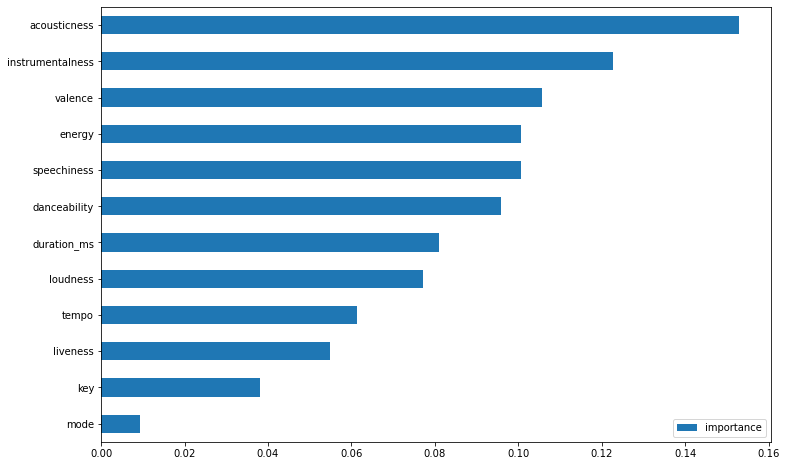

In [ ]:
imp = pd.DataFrame(best.feature_importances_, index=x_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
y_pred = gs.predict(x_test)
print(metrics.classification_report(y_pred, y_test))

                 precision    recall  f1-score   support

     Electronic       0.71      0.48      0.57        21
           Folk       0.00      0.00      0.00         0
        Hip-Hop       0.80      1.00      0.89         4
          Indie       0.00      0.00      0.00         0
           Jazz       0.00      0.00      0.00         0
          Metal       1.00      0.67      0.80         9
          Other       0.17      0.18      0.17        11
            Pop       0.00      0.00      0.00         0
           Rock       0.27      0.21      0.24        14
Symphonic_Metal       0.33      1.00      0.50         1

       accuracy                           0.43        60
      macro avg       0.33      0.35      0.32        60
   weighted avg       0.55      0.43      0.48        60



/home/gladkov2/anaconda3/envs/bi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Случайный лес

In [ ]:
!echo "Threads/core: $(nproc --all)"

Threads/core: 2


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dfs[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']], dfs.basic_genre, test_size=0.2, stratify=dfs.basic_genre, random_state=42)

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
param_grid = {
    
    'max_depth': list(range(1, 12, 2)),
    'min_samples_leaf': list(range(1, 10, 2)),
    'min_samples_split': list(range(1, 10, 2)),
    'n_estimators': list(range(100, 1000, 50)),
    'criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 20, verbose = 2)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 325 tasks      | elapsed:  3.2min
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:  6.1min
[Parallel(n_jobs=20)]: Done 973 tasks      | elapsed: 10.1min
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed: 14.5min
[Parallel(n_jobs=20)]: Done 1945 tasks      | elapsed: 20.2min
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed: 26.8min
[Parallel(n_jobs=20)]: Done 3241 tasks      | elapsed: 34.4min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed: 42.7min
[Parallel(n_jobs=20)]: Done 4861 tasks      | elapsed: 52.1min
[Parallel(n_jobs=20)]: Done 5792 tasks      | elapsed: 62.2min
[Parallel(n_jobs=20)]: Done 6805 tasks      | elapsed: 73.2min
[Parallel(n_jobs=20)]: Done 7898 tasks      | elapsed: 85.3min
[Parallel(n_jobs=20)]: Done 9073 tasks      | 

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              warm_start=False),
             iid='deprecated', n_jobs=20,
    

In [ ]:
ypred = grid_search.predict(x_test)

In [ ]:
grid_search

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              warm_start=False),
             iid='deprecated', n_jobs=20,
    

In [ ]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(metrics.classification_report(ypred, y_test))

                 precision    recall  f1-score   support

     Electronic       0.79      0.52      0.63        21
        Hip-Hop       0.25      0.50      0.33         2
          Indie       0.00      0.00      0.00         0
          Metal       0.83      0.71      0.77         7
          Other       0.59      0.40      0.48        25
            Pop       0.00      0.00      0.00         0
           Rock       0.00      0.00      0.00         4
Symphonic_Metal       0.00      0.00      0.00         1

       accuracy                           0.45        60
      macro avg       0.31      0.27      0.28        60
   weighted avg       0.63      0.45      0.52        60



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.Series(y_test).value_counts()

Other              17
Electronic         14
Rock               11
Metal               6
Hip-Hop             4
Symphonic_Metal     3
Pop                 3
Indie               2
Name: basic_genre, dtype: int64

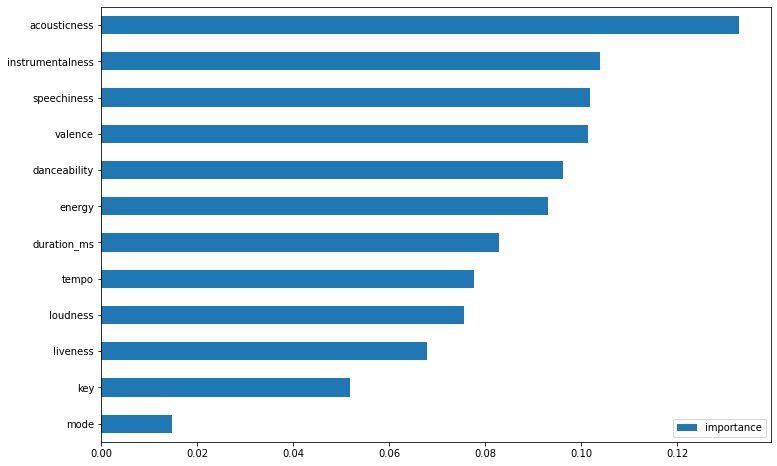

In [ ]:
imp = pd.DataFrame(rf.feature_importances_, index=x_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
with open('rf_dumped.pkl', 'wb') as f:
    pickle.dump(grid_search, f) 

### Оч быстрая нейросетка

In [ ]:
dfs = pd.read_csv("df_37.csv")
main_genres =  dfs[['source_name','coarse_genre']].groupby("coarse_genre").count().sort_values('source_name', ascending=False).index[:9].to_list()
dfs['basic_genre'] = dfs['coarse_genre']
dfs.loc[~dfs["basic_genre"].isin(main_genres), "basic_genre"] = "Other"
pd.Series(dfs.basic_genre).value_counts()

Electronic         68
Other              62
Rock               53
Metal              29
Hip-Hop            24
Symphonic_Metal    18
Pop                15
Folk               11
Indie              11
Jazz                9
Name: basic_genre, dtype: int64

In [ ]:
dfs

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track,artist,source_name,student,coarse_genre,genre1,genre2,genre3,basic_genre
0,0,0.759,0.553,11,-8.489,0,0.0620,0.00437,0.000123,0.2200,0.5700,111.037,audio_features,6KMNLtxG9B9w32EKGz2ryk,spotify:track:6KMNLtxG9B9w32EKGz2ryk,https://api.spotify.com/v1/tracks/6KMNLtxG9B9w...,https://api.spotify.com/v1/audio-analysis/6KMN...,180372,4,Нет мира без тебя,Ranetki Girls,Нет_мира_без_тебя-Ранетки,Роман_Кругликов,Rock,Pop_Rock,NaN,NaN,Rock
1,1,0.587,0.698,1,-8.948,1,0.0943,0.01520,0.000000,0.4420,0.0985,133.954,audio_features,712uvW1Vezq8WpQi38v2L9,spotify:track:712uvW1Vezq8WpQi38v2L9,https://api.spotify.com/v1/tracks/712uvW1Vezq8...,https://api.spotify.com/v1/audio-analysis/712u...,310720,4,"Bitch, Don’t Kill My Vibe",Kendrick Lamar,Bitch_Dont_Kill_My_Vibe-Kendrick_Lamar,Данил_Литвинов,Hip-Hop,Rap,Weas-Ccoast_Hip-Hop,NaN,Hip-Hop
2,2,0.568,0.837,1,-6.138,1,0.0266,0.09000,0.058700,0.0994,0.8530,104.988,audio_features,3c4bJL7mARZvd387847GsC,spotify:track:3c4bJL7mARZvd387847GsC,https://api.spotify.com/v1/tracks/3c4bJL7mARZv...,https://api.spotify.com/v1/audio-analysis/3c4b...,245867,4,Precious,Depeche Mode,Precious-Depeche_Mode,Данил_Литвинов,Rock,Electronic_Rock,Soft_Rock,NaN,Rock
3,3,0.516,0.832,6,-5.350,0,0.0606,0.51500,0.000002,0.3610,0.5380,168.119,audio_features,11YO6bRr4WZiOlkgwu0IiF,spotify:track:11YO6bRr4WZiOlkgwu0IiF,https://api.spotify.com/v1/tracks/11YO6bRr4WZi...,https://api.spotify.com/v1/audio-analysis/11YO...,138373,4,Ultima Thule,Oxxxymiron,Ultima_Thule-Oxxxymiron,Данил_Литвинов,Hip-Hop,Rap,NaN,NaN,Hip-Hop
4,4,0.507,0.889,7,-2.755,0,0.0860,0.04950,0.000000,0.0983,0.3330,135.021,audio_features,0GLyqTysS0DFoeKjURtB8s,spotify:track:0GLyqTysS0DFoeKjURtB8s,https://api.spotify.com/v1/tracks/0GLyqTysS0DF...,https://api.spotify.com/v1/audio-analysis/0GLy...,238360,4,unravel,TK from Ling tosite sigure,Unravel-TK,Данил_Литвинов,Rock,Anime,NaN,NaN,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0.712,0.953,11,-8.409,1,0.0466,0.03880,0.914000,0.1110,0.2130,125.008,audio_features,74RlRknY02u9U0c76wXUqj,spotify:track:74RlRknY02u9U0c76wXUqj,https://api.spotify.com/v1/tracks/74RlRknY02u9...,https://api.spotify.com/v1/audio-analysis/74Rl...,341163,4,Tantrum,Throwing Snow,Tantrum-Throwing_Snow,Паша_Дерябин,Electronic,Dubstep,NaN,NaN,Electronic
296,296,0.736,0.759,9,-7.066,1,0.0347,0.05730,0.207000,0.0778,0.4850,128.039,audio_features,5H0CfA9GaNg0wROR9K3X3K,spotify:track:5H0CfA9GaNg0wROR9K3X3K,https://api.spotify.com/v1/tracks/5H0CfA9GaNg0...,https://api.spotify.com/v1/audio-analysis/5H0C...,170059,4,The Veldt - Radio Edit,deadmau5,The_Veldt-deadmau5_feat_Chris_James,Паша_Дерябин,Electronic,House,NaN,NaN,Electronic
297,297,0.463,0.525,6,-13.032,0,0.0598,0.13000,0.926000,0.1400,0.1520,125.056,audio_features,0VG7dnqLP38Jpvld0lMk5m,spotify:track:0VG7dnqLP38Jpvld0lMk5m,https://api.spotify.com/v1/tracks/0VG7dnqLP38J...,https://api.spotify.com/v1/audio-analysis/0VG7...,376320,4,The Violent Sequence,Worriedaboutsatan,The_Violent_Sequence-Worriedaboutsatan,Паша_Дерябин,Electronic,Techno,NaN,NaN,Electronic
298,298,0.685,0.630,1,-10.909,1,0.0417,0.06700,0.841000,0.1040,0.7880,119.993,audio_features,1bweOqaO6SIGRRMupc7zMm,spotify:track:1bweOqaO6SIGRRMupc7zMm,https://api.spotify.com/v1/tracks/1bweOqaO6SIG...,https://api.spotify.com/v1/audio-analysis/1bwe...,214154,4,Voyager - Original Mix,Jasper Byrne,Voyager-Jasper_Byrne,Паша_Дерябин,Electronic,Synthwave,NaN,NaN,Electronic


In [ ]:
def make_input_fn(df):
  def pandas_to_tf(pdcol):
    # convert the pandas column values to float
    t = tf.constant(pdcol.astype('float32').values)
    # take the column which is of shape (N) and make it (N, 1)
    return tf.expand_dims(t, -1)

  def input_fn():
    # create features, columns
    features = {k: pandas_to_tf(df[k]) for k in FEATURES}
    labels = tf.constant(df[TARGET].values)
    return features, labels
  return input_fn

def make_feature_cols():
  input_columns = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]
  return input_columns


In [ ]:
tf.constant(dfs_w.astype('float32').values)

ValueError: ignored

In [ ]:
def make_input_fn(df):
  def pandas_to_tf(pdcol):
    # convert the pandas column values to float
    t = tf.constant(pdcol.astype('float32').values)
    # take the column which is of shape (N) and make it (N, 1)
    return tf.expand_dims(t, -1)

  def input_fn():
    # create features, columns
    features = {k: pandas_to_tf(df[k]) for k in FEATURES}
    labels = tf.constant(df[TARGET].values)
    return features, labels
  return input_fn

def make_feature_cols():
  input_columns = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]
  return input_columns


In [ ]:
!nvidia-smi

Wed Apr 21 15:20:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |    351MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
dfs_w

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,basic_genre
0,0.759,0.553,11,-8.489,0,0.0620,0.00437,0.000123,0.2200,0.5700,111.037,180372,Rock
1,0.587,0.698,1,-8.948,1,0.0943,0.01520,0.000000,0.4420,0.0985,133.954,310720,Hip-Hop
2,0.568,0.837,1,-6.138,1,0.0266,0.09000,0.058700,0.0994,0.8530,104.988,245867,Rock
3,0.516,0.832,6,-5.350,0,0.0606,0.51500,0.000002,0.3610,0.5380,168.119,138373,Hip-Hop
4,0.507,0.889,7,-2.755,0,0.0860,0.04950,0.000000,0.0983,0.3330,135.021,238360,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.712,0.953,11,-8.409,1,0.0466,0.03880,0.914000,0.1110,0.2130,125.008,341163,Electronic
296,0.736,0.759,9,-7.066,1,0.0347,0.05730,0.207000,0.0778,0.4850,128.039,170059,Electronic
297,0.463,0.525,6,-13.032,0,0.0598,0.13000,0.926000,0.1400,0.1520,125.056,376320,Electronic
298,0.685,0.630,1,-10.909,1,0.0417,0.06700,0.841000,0.1040,0.7880,119.993,214154,Electronic


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dfs[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']], dfs.basic_genre, test_size=0.2, stratify=dfs.basic_genre, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import random 
import tensorflow as tf
random.set_seed(42)

def get_model():
    #создаем модель
    model = Sequential()
    #добавляем слои, Dense - простой полносвязный слой (обязательно указывать размерность входного слоя)
    model.add(Dense(300, input_dim=12, activation='relu'))
    #dropout выключает часть нейронов на данной эпохе, помогает от переобучения, делает модель устойчивее
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    #последний слой будет отвечать за предсказание, сигмоида приведет предсказания к промежутку [0,1]
    model.add(Dense(1, activation='sigmoid'))
    #переод обучением модель нужно скомпилировать (как и в tf)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
  
model = get_model()

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [ ]:

history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, shuffle=True, callbacks=[es])

Epoch 1/100


UnimplementedError: ignored

In [ ]:
from matplotlib import pyplot as plt

def visualize_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
  
visualize_plot(history)

In [ ]:
#оценим метрики на тестовом датасете
pred = model.predict(x_test)

#определим порог для предсказаний
thrs=0.5
pr = pred.copy()
pr[pr>thrs] = 1
pr[pr<thrs] = 0

f1 = f1_score(y_true=y_test, y_pred=pr)
cr = classification_report(pr, y_test))
print(f1)
print(cr)

In [ ]:
dfs_w = dfs[['danceability',
  'energy',
  'key',
  'loudness',
  'mode',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'liveness',
  'valence',
  'tempo', 
  'duration_ms', 'basic_genre']]

In [ ]:
dfs_n = dfs_w.drop(columns=["basic_genre"])
dfs_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      300 non-null    float64
 1   energy            300 non-null    float64
 2   key               300 non-null    int64  
 3   loudness          300 non-null    float64
 4   mode              300 non-null    int64  
 5   speechiness       300 non-null    float64
 6   acousticness      300 non-null    float64
 7   instrumentalness  300 non-null    float64
 8   liveness          300 non-null    float64
 9   valence           300 non-null    float64
 10  tempo             300 non-null    float64
 11  duration_ms       300 non-null    int64  
dtypes: float64(9), int64(3)
memory usage: 28.2 KB


In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dfs_w[:-1])

ValueError: ignored

In [ ]:
pca = PCA()
x = StandardScaler().fit_transform(dfs_n)
pca_results = pca.fit_transform(x)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.23137301 0.15111739 0.10896472 0.09175665 0.08451069 0.07069992
 0.06368897 0.06057299 0.05843968 0.03987096 0.02652617 0.01247885]


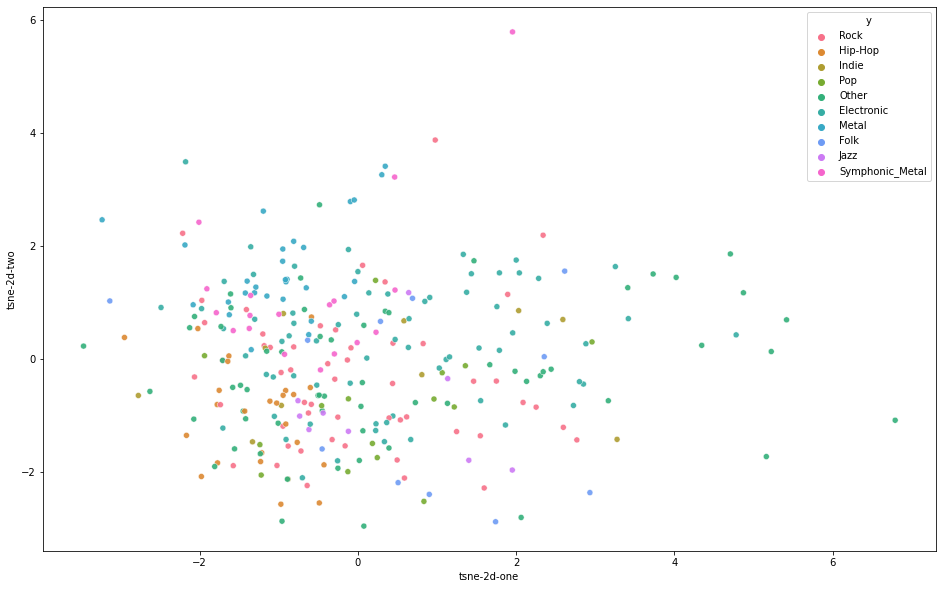

In [ ]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = pca_results[:,0]
df_subset['tsne-2d-two'] = pca_results[:,1]
df_subset['y'] = dfs_w['basic_genre']
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("husl", 10),
    data=df_subset,
    legend="full",
    alpha=0.9
)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
x = StandardScaler().fit_transform(dfs_n)
tsne_results = tsne.fit_transform(x)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 1.565223
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.709877
[t-SNE] KL divergence after 1050 iterations: 0.856817


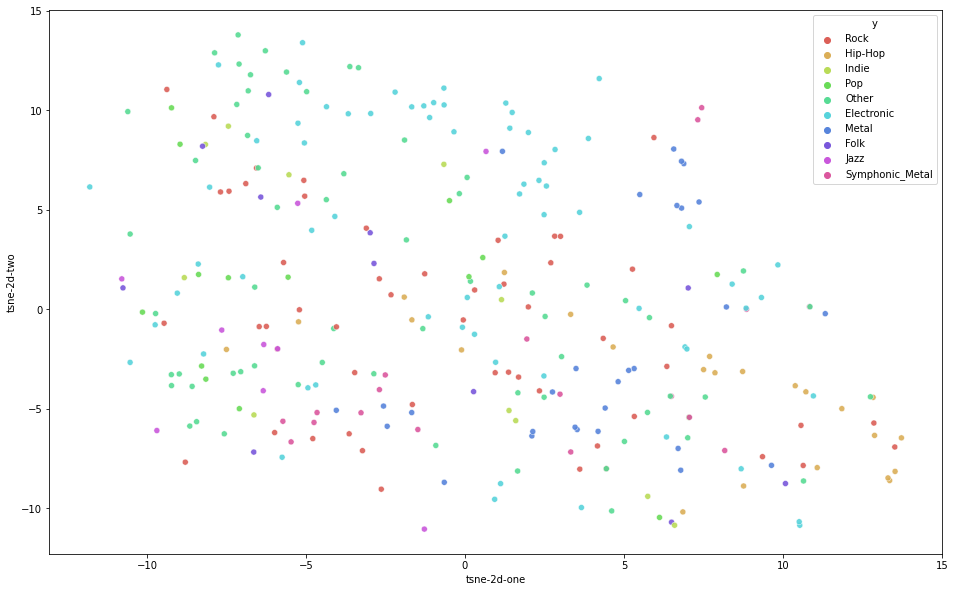

In [ ]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = dfs_w['basic_genre']
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.9
)